The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


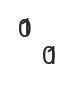

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import dataframe_image as dfi
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels
from src.data_processing import get_dataset, BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS, get_aa_properties
from src.metrics import get_predictions, get_roc, get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.utils import pkl_load, pkl_dump, get_palette
from src.bootstrap import bootstrap_eval, get_pval, plot_pval
from src.models import FFNetPipeline
from src.bootstrap import get_pval, plot_pval
import torch
from torch import nn
from torch import functional as F
PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
tmppal = sns.color_palette('hsv', n_colors=15)
NEWPAL = HSV + [tmppal[-3], tmppal[7]]
mpl.rcParams['figure.dpi'] = 180

In [3]:
cedar_aligned = pd.read_csv('../data/aligned_icore/230418_cedar_aligned.csv')
prime_aligned = pd.read_csv('../data/aligned_icore/230418_prime_aligned.csv')
viral = pd.read_csv('../data/other/viral.csv').rename(columns={'sequence':'Peptide'})

# self explo

In [3]:
from src.models import *

In [80]:
def sliding_window(x, window_size):
    # Compute the number of windows per sequence
    num_windows = x.size(1) - window_size + 1

    # Create a tensor of shape (N, num_windows, window_size, D) containing the sliding windows
    windows = torch.nn.functional.unfold(x.transpose(1, 2), (window_size, 1)).transpose(1, 2).view(x.size(0), num_windows, window_size, x.size(2))

    # Mask out the padded positions
    mask = (x != 0).unsqueeze(-1).expand_as(windows)
    windows = torch.masked_select(windows, mask).view(x.size(0), num_windows, -1)

    return windows

In [242]:
from src.data_processing import encode_batch
sample = cedar_aligned.sample(100, random_state=100)
sample.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,HLA,agg_label,fold,Peptide,wild_type,icore_mut,core_mut,...,icore_improves_binder_0_75,mixed_input_binder_0_75,mixed_rank_binder_0_75,icore_improves_1,mixed_input_1,mixed_rank_1,icore_improves_binder_1,mixed_input_binder_1,mixed_rank_binder_1,expanded_input
996,996,996,996,HLA-A0201,0,1,IMQPSVVIPA,IVQPSVVIPA,MQPSVVIPA,MQPSVVIPA,...,False,IMQPSVVIPA,2.8394,False,IMQPSVVIPA,2.8394,False,IMQPSVVIPA,2.8394,MQPSVVIPA
249,249,249,249,HLA-A2402,0,5,AYLEAIHTF,AYLEAIHNF,AYLEAIHTF,AYLEAIHTF,...,False,AYLEAIHTF,0.0006,False,AYLEAIHTF,0.0006,False,AYLEAIHTF,0.0006,AYLEAIHTF
774,774,774,774,HLA-B3901,0,7,GRMRSLEAL,GRMRCLEAL,GRMRSLEAL,GRMRSLEAL,...,False,GRMRSLEAL,0.2547,False,GRMRSLEAL,0.2547,False,GRMRSLEAL,0.2547,GRMRSLEAL
1617,1617,1617,1617,HLA-C0702,1,8,LYIWFKTACL,LYLWFKTACL,YIWFKTACL,YIWFKTACL,...,False,LYIWFKTACL,4.9286,False,LYIWFKTACL,4.9286,False,LYIWFKTACL,4.9286,YIWFKTACL
3004,3004,3004,3004,HLA-B0801,0,1,YTTVRALTL,YTTVRALTR,YTTVRALTL,YTTVRALTL,...,False,YTTVRALTL,0.1560,False,YTTVRALTL,0.1560,False,YTTVRALTL,0.1560,YTTVRALTL


In [246]:
x = encode_batch(sample['Peptide'].values, 12, 'onehot')
x.shape

torch.Size([100, 12, 20])

In [224]:
# Say K = 5
max_len = 12
N = 3
K = 5
x_base = torch.rand([N, max_len, 20])
x = x.view(N,-1)
y = torch.randint(1, size=(N, 1)).float()
y[N-1]=1
y_exp = y.expand((N, max_len-K+1)).view(-1, max_len-K+1, 1)


criterion = nn.BCEWithLogitsLoss(reduction='none')
# Here need to fix expander to return the x_expand_flat 
xp = InputExpander(window_size=K, max_len=max_len, indel=False)
z=xp(x_base)

n_hidden = 10
model = nn.Sequential(nn.Linear(K*20, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 1))

# expanding input stuff
x_sliding = x_base.unfold(1, K, 1)
# Reshape the tensor to the desired output shape
x_expand = x_sliding.transpose(2, 3).reshape(len(x_base), max_len-K+1, K, 20)
x_expand_flat = x_expand.flatten(2,3)

y_pred = model(x_expand_flat)
# x_expand should be correct and z is transposed i.e. wrong
x_expand.shape, z.shape, x_base.shape, (x_base[0][3:3+K,:] == x_expand[0,3,:]).all(), x_expand_flat.shape



(torch.Size([3, 8, 5, 20]),
 torch.Size([3, 5, 8, 20]),
 torch.Size([3, 12, 20]),
 tensor(True),
 torch.Size([3, 8, 100]))

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn.functional import binary_cross_entropy_with_logits as bce_with_logits

class SlidingWindowDataset(Dataset):
    def __init__(self, x, y, window_size):
        self.x = x
        self.y = y
        self.window_size = window_size

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x_window = self.x[idx][:, None, :]
        x_window = nn.functional.unfold(x_window, (1, self.window_size))[0]
        y = self.y[idx]
        return x_window, y

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(20, 10)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(10, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        return x

def train(model, optimizer, criterion, dataloader):
    model.train()
    total_loss = 0.0
    for x_batch, y_batch in dataloader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(x_batch)
    return total_loss / len(dataloader.dataset)

def evaluate(model, criterion, dataloader):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            total_loss += loss.item() * len(x_batch)
    return total_loss / len(dataloader.dataset)

# Define the input tensor x and target tensor y
x = torch.randn(3000, 10, 20)
y = torch.randint(0, 2, (3000, 1)).float()

# Define the window size and batch size
window_size = 5
batch_size = 128

# Define the dataset and dataloader
dataset = SlidingWindowDataset(x, y, window_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the model, loss function, and optimizer
model = Net()
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters())

# Train the model
for epoch in range(10):
    train_loss = train(model, optimizer, criterion, dataloader)
    valid_loss = evaluate(model, criterion, dataloader)
    print(f"Epoch {epoch + 1:03d}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

# Compute the best scores
model.eval()
best_scores = []
with torch.no_grad():
    for x_batch, y_batch in dataloader:
        scores = model(x_batch).squeeze()
        losses = bce_with_logits(scores, y_batch)
        best_indices = losses.argmin(dim=1)
        best_scores_batch = scores.gather(1, best_indices.view(-1, 1)).view(-1, 1)
        best_scores.append


# tests

In [312]:
from src.models import NNAlign, NNAlignWrapper
from src.datasets import NNAlignDataset, get_NNAlign_dataloader
from src.train_eval import train_model_step, eval_model_step
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch import optim

window_size = 6
max_len = 12
n_hidden = 50
p_drop = 0.25
encoding = 'BL62LO'
indel=False
n_epochs = 500
activation = nn.SELU()
model = NNAlignWrapper(n_hidden=n_hidden, window_size=window_size, activation = activation, dropout=p_drop)

train, test = train_test_split(cedar_aligned, test_size=1/4)
valid, test = train_test_split(test, test_size=1/2)

train_dataset = NNAlignDataset(train, max_len, window_size, encoding=encoding)
train_loader = DataLoader(train_dataset, batch_size = 128, sampler=torch.utils.data.RandomSampler(valid_dataset))

x,y = train_dataset[:10]
print('checking padded inputs\n', x[3][-1].view(window_size, 20))


valid_dataset = NNAlignDataset(valid, max_len, window_size, encoding=encoding)
valid_loader = DataLoader(valid_dataset, batch_size = 64, sampler=torch.utils.data.RandomSampler(valid_dataset))

test_dataset = NNAlignDataset(test, max_len, window_size, encoding=encoding)
test_loader = DataLoader(test_dataset, batch_size = 64, sampler=torch.utils.data.RandomSampler(test_dataset))

prime_aligned = pd.read_csv('../data/aligned_icore/230418_prime_aligned.csv')
prime_dataset = NNAlignDataset(prime_aligned, max_len, window_size, encoding=encoding)
prime_loader = DataLoader(prime_dataset, batch_size=64, sampler=torch.utils.data.RandomSampler(prime_dataset))


optimizer = optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-2)
criterion = nn.BCEWithLogitsLoss(reduction='mean')

train_losses=[]
valid_losses=[]
test_losses=[]
prime_losses = []
train_aucs=[]
valid_aucs=[]
test_aucs=[]
prime_aucs = []

print('Before training')
loss, metrics = eval_model_step(model, criterion, train_loader)
train_losses.append(loss)
train_aucs.append(metrics['auc'])
print('train', f'{loss:.3e}', 'auc', round(metrics['auc'],3), 'auc_01', round(metrics['auc_01'],3), 'acc', round(metrics['accuracy'],3), 'prec', round(metrics['precision'],3))
loss, metrics = eval_model_step(model, criterion, valid_loader)
valid_losses.append(loss)
valid_aucs.append(metrics['auc'])
print('valid', f'{loss:.3e}', 'auc', round(metrics['auc'],3), 'auc_01', round(metrics['auc_01'],3), 'acc', round(metrics['accuracy'],3), 'prec', round(metrics['precision'],3))
loss, metrics = eval_model_step(model, criterion, test_loader)
test_losses.append(loss)
test_aucs.append(metrics['auc'])
print('eval', f'{loss:.3e}', 'auc', round(metrics['auc'],3), 'auc_01', round(metrics['auc_01'],3), 'acc', round(metrics['accuracy'],3), 'prec', round(metrics['precision'],3))
loss, metrics = eval_model_step(model, criterion, prime_loader)
prime_losses.append(loss)
prime_aucs.append(metrics['auc'])        
print('prime', f'{loss:.3e}', 'auc', round(metrics['auc'],3), 'auc_01', round(metrics['auc_01'],3), 'acc', round(metrics['accuracy'],3), 'prec', round(metrics['precision'],3),'\n\n')
for e in range(1,n_epochs+1):
    loss, metrics = train_model_step(model, criterion, optimizer, train_loader)
    train_losses.append(loss)
    train_aucs.append(metrics['auc'])
    if e%int(n_epochs/10)==0 or e ==1:
        print(f'EPOCH = {e}\n\n')
        print('train', f'{loss:.3e}', 'auc', round(metrics['auc'],3), 'auc_01', round(metrics['auc_01'],3), 'acc', round(metrics['accuracy'],3), 'prec', round(metrics['precision'],3))
    loss, metrics = eval_model_step(model, criterion, valid_loader)
    valid_losses.append(loss)
    valid_aucs.append(metrics['auc'])
    if e%int(n_epochs/10)==0 or e ==1:
        print('valid', f'{loss:.3e}', 'auc', round(metrics['auc'],3), 'auc_01', round(metrics['auc_01'],3), 'acc', round(metrics['accuracy'],3), 'prec', round(metrics['precision'],3))
    loss, metrics = eval_model_step(model, criterion, test_loader)
    test_losses.append(loss)
    test_aucs.append(metrics['auc'])
    if e%int(n_epochs/10)==0 or e ==1:
        print('eval', f'{loss:.3e}', 'auc', round(metrics['auc'],3), 'auc_01', round(metrics['auc_01'],3), 'acc', round(metrics['accuracy'],3), 'prec', round(metrics['precision'],3))
    loss, metrics = eval_model_step(model, criterion, prime_loader)
    prime_losses.append(loss)
    prime_aucs.append(metrics['auc'])
    if e%int(n_epochs/10)==0 or e ==1:
        print('prime', f'{loss:.3e}', 'auc', round(metrics['auc'],3), 'auc_01', round(metrics['auc_01'],3), 'acc', round(metrics['accuracy'],3), 'prec', round(metrics['precision'],3),'\n\n')

checking padded inputs
 tensor([[  1.,  -1.,   1.,   0.,  -1.,   0.,   0.,   0.,  -1.,  -2.,  -2.,   0.,
          -1.,  -2.,  -1.,   4.,   1.,  -3.,  -2.,  -2.],
        [  1.,  -1.,   1.,   0.,  -1.,   0.,   0.,   0.,  -1.,  -2.,  -2.,   0.,
          -1.,  -2.,  -1.,   4.,   1.,  -3.,  -2.,  -2.],
        [ -1.,  -2.,  -3.,  -4.,  -1.,  -2.,  -3.,  -4.,  -3.,   2.,   4.,  -2.,
           2.,   0.,  -3.,  -2.,  -1.,  -2.,  -1.,   1.],
        [-12., -12., -12., -12., -12., -12., -12., -12., -12., -12., -12., -12.,
         -12., -12., -12., -12., -12., -12., -12., -12.],
        [-12., -12., -12., -12., -12., -12., -12., -12., -12., -12., -12., -12.,
         -12., -12., -12., -12., -12., -12., -12., -12.],
        [-12., -12., -12., -12., -12., -12., -12., -12., -12., -12., -12., -12.,
         -12., -12., -12., -12., -12., -12., -12., -12.]])
Before training
train 1.242e-01 auc 0.444 auc_01 0.487 acc 0.388 prec 0.172
valid 7.267e-01 auc 0.536 auc_01 0.487 acc 0.48 prec 0.22
eval 7.

Text(0.5, 0.98, 'Dropout only')

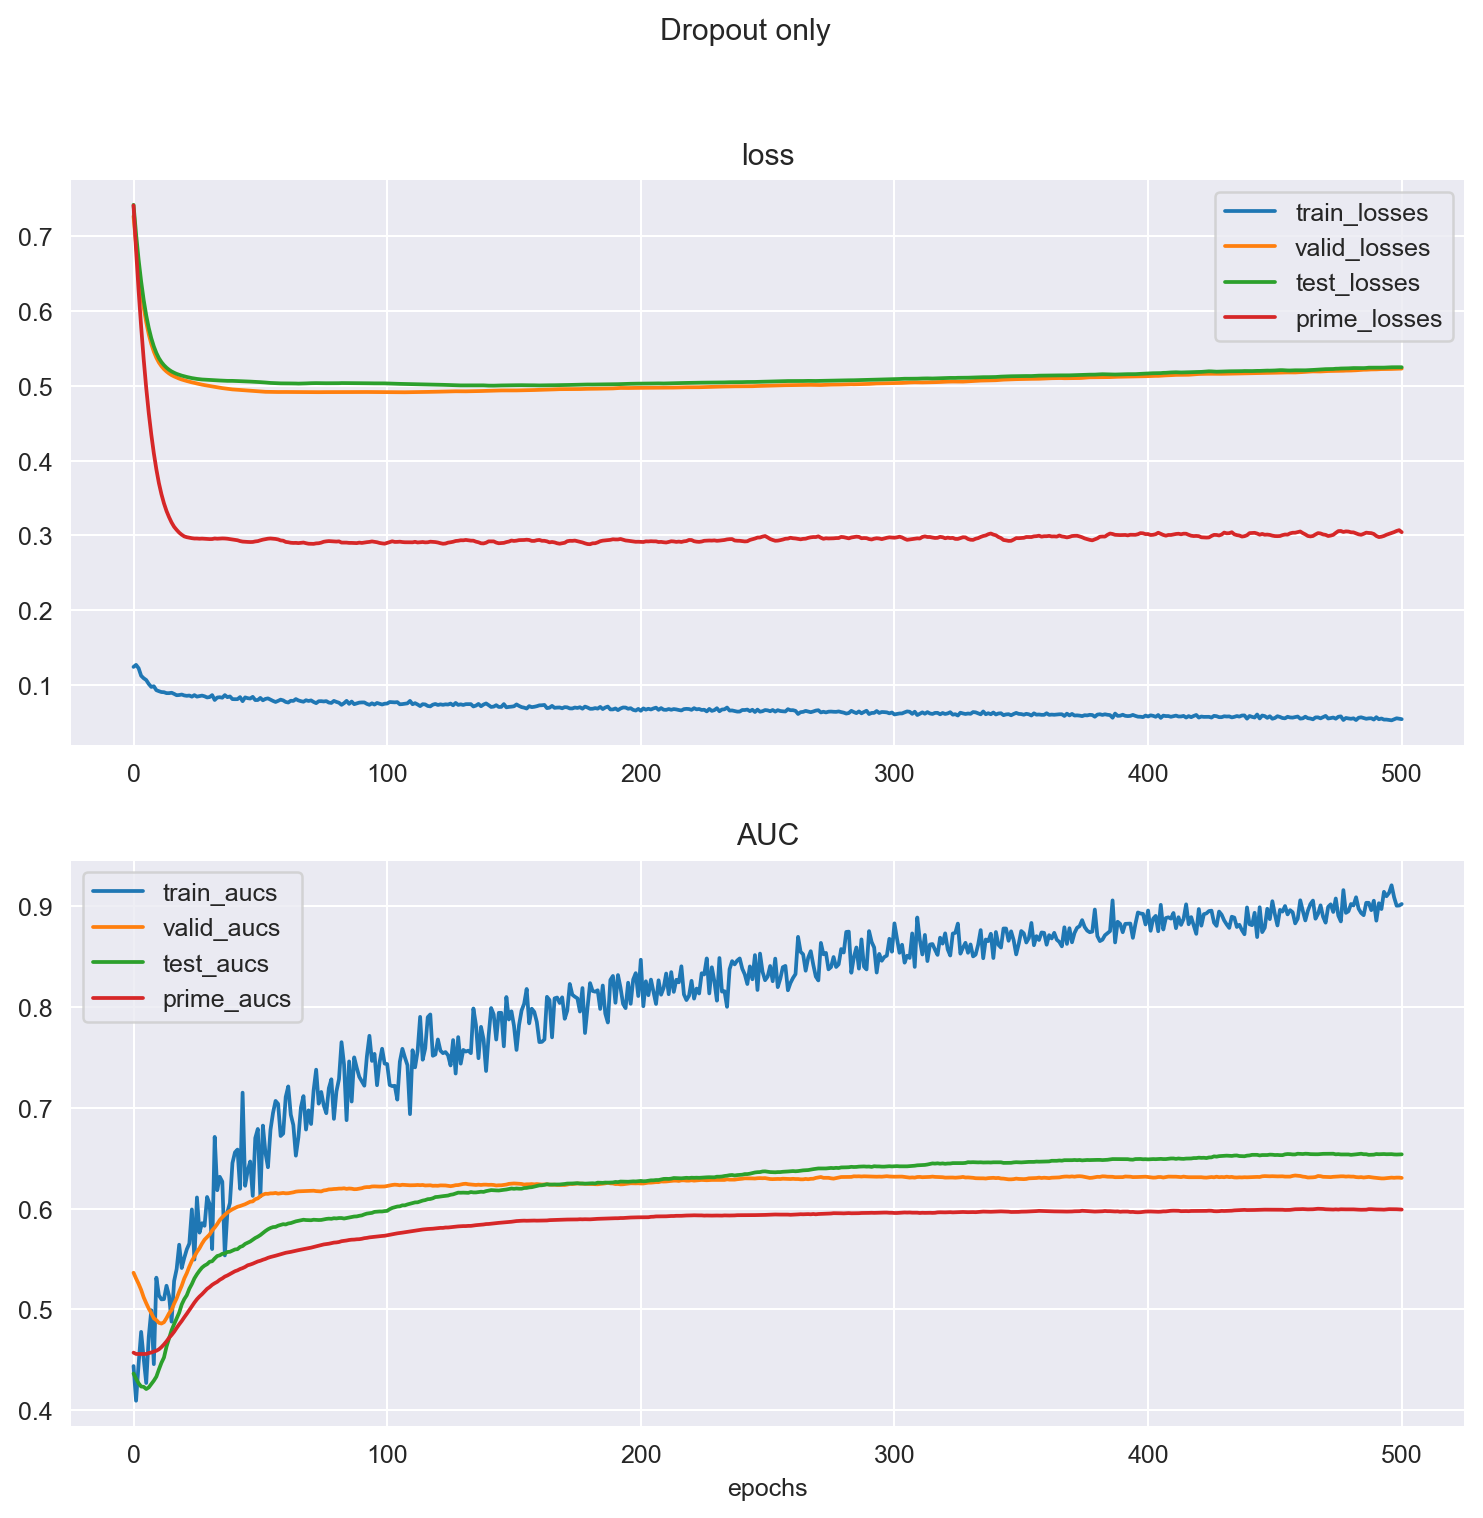

In [322]:
f,a = plt.subplots(2,1, figsize=(10,9))
a = a.ravel()
a[0].plot(train_losses, label='train_losses')
a[0].plot(valid_losses, label='valid_losses')
a[0].plot(test_losses, label='test_losses')
a[0].plot(prime_losses, label='prime_losses')
a[0].legend()
a[0].set_title('loss')
a[1].plot(train_aucs, label='train_aucs')
a[1].plot(valid_aucs, label='valid_aucs')
a[1].plot(test_aucs, label='test_aucs')
a[1].plot(prime_aucs, label='prime_aucs')
a[1].legend()
a[1].set_title('AUC')
a[1].set_xlabel('epochs')
f.suptitle('Dropout only')

In [3]:
from src.models import NNAlign, NNAlignWrapper
from src.datasets import NNAlignDataset, get_NNAlign_dataloader
from src.train_eval import train_model_step, eval_model_step
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch import optim

window_size = 6
max_len = 12
n_hidden = 50
p_drop = 0.25
encoding = 'BL62LO'
indel=False
n_epochs = 500

train, test = train_test_split(cedar_aligned, test_size=1/4)
valid, test = train_test_split(test, test_size=1/2)

train_dataset = NNAlignDataset(train, max_len, window_size, encoding=encoding)
train_loader = DataLoader(train_dataset, batch_size = 64, sampler=torch.utils.data.RandomSampler(valid_dataset))

x,y = train_dataset[:10]
print('checking padded inputs\n', x[3][-1].view(window_size, 20))


valid_dataset = NNAlignDataset(valid, max_len, window_size, encoding=encoding)
valid_loader = DataLoader(valid_dataset, batch_size = 64, sampler=torch.utils.data.RandomSampler(valid_dataset))

test_dataset = NNAlignDataset(test, max_len, window_size, encoding=encoding)
test_loader = DataLoader(test_dataset, batch_size = 64, sampler=torch.utils.data.RandomSampler(test_dataset))

prime_aligned = pd.read_csv('../data/aligned_icore/230418_prime_aligned.csv')
prime_dataset = NNAlignDataset(prime_aligned, max_len, window_size, encoding=encoding)
prime_loader = DataLoader(prime_dataset, batch_size=64, sampler=torch.utils.data.RandomSampler(prime_dataset))


model = NNAlignWrapper(n_hidden=n_hidden, window_size=window_size, activation = nn.SELU(), dropout=p_drop)
optimizer = optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-2)
criterion = nn.BCEWithLogitsLoss(reduction='mean')

train_losses=[]
valid_losses=[]
test_losses=[]
prime_losses = []
train_aucs=[]
valid_aucs=[]
test_aucs=[]
prime_aucs = []

print('Before training')
loss, metrics = eval_model_step(model, criterion, train_loader)
train_losses.append(loss)
train_aucs.append(metrics['auc'])
print('train', f'{loss:.3e}', 'auc', round(metrics['auc'],3), 'auc_01', round(metrics['auc_01'],3), 'acc', round(metrics['accuracy'],3), 'prec', round(metrics['precision'],3))
loss, metrics = eval_model_step(model, criterion, valid_loader)
valid_losses.append(loss)
valid_aucs.append(metrics['auc'])
print('valid', f'{loss:.3e}', 'auc', round(metrics['auc'],3), 'auc_01', round(metrics['auc_01'],3), 'acc', round(metrics['accuracy'],3), 'prec', round(metrics['precision'],3))
loss, metrics = eval_model_step(model, criterion, test_loader)
test_losses.append(loss)
test_aucs.append(metrics['auc'])
print('eval', f'{loss:.3e}', 'auc', round(metrics['auc'],3), 'auc_01', round(metrics['auc_01'],3), 'acc', round(metrics['accuracy'],3), 'prec', round(metrics['precision'],3))
loss, metrics = eval_model_step(model, criterion, prime_loader)
prime_losses.append(loss)
prime_aucs.append(metrics['auc'])        
print('prime', f'{loss:.3e}', 'auc', round(metrics['auc'],3), 'auc_01', round(metrics['auc_01'],3), 'acc', round(metrics['accuracy'],3), 'prec', round(metrics['precision'],3),'\n\n')
for e in range(1,n_epochs+1):
    loss, metrics = train_model_step(model, criterion, optimizer, train_loader)
    train_losses.append(loss)
    train_aucs.append(metrics['auc'])
    if e%int(n_epochs/10)==0 or e ==1:
        print(f'EPOCH = {e}\n\n')
        print('train', f'{loss:.3e}', 'auc', round(metrics['auc'],3), 'auc_01', round(metrics['auc_01'],3), 'acc', round(metrics['accuracy'],3), 'prec', round(metrics['precision'],3))
    loss, metrics = eval_model_step(model, criterion, valid_loader)
    valid_losses.append(loss)
    valid_aucs.append(metrics['auc'])
    if e%int(n_epochs/10)==0 or e ==1:
        print('valid', f'{loss:.3e}', 'auc', round(metrics['auc'],3), 'auc_01', round(metrics['auc_01'],3), 'acc', round(metrics['accuracy'],3), 'prec', round(metrics['precision'],3))
    loss, metrics = eval_model_step(model, criterion, test_loader)
    test_losses.append(loss)
    test_aucs.append(metrics['auc'])
    if e%int(n_epochs/10)==0 or e ==1:
        print('eval', f'{loss:.3e}', 'auc', round(metrics['auc'],3), 'auc_01', round(metrics['auc_01'],3), 'acc', round(metrics['accuracy'],3), 'prec', round(metrics['precision'],3))
    loss, metrics = eval_model_step(model, criterion, prime_loader)
    prime_losses.append(loss)
    prime_aucs.append(metrics['auc'])
    if e%int(n_epochs/10)==0 or e ==1:
        print('prime', f'{loss:.3e}', 'auc', round(metrics['auc'],3), 'auc_01', round(metrics['auc_01'],3), 'acc', round(metrics['accuracy'],3), 'prec', round(metrics['precision'],3),'\n\n')
        
f,a = plt.subplots(2,1, figsize=(10,9))
a = a.ravel()
a[0].plot(train_losses, label='train_losses')
a[0].plot(valid_losses, label='valid_losses')
a[0].plot(test_losses, label='test_losses')
a[0].plot(prime_losses, label='prime_losses')
a[0].legend()
a[0].set_title('loss')
a[1].plot(train_aucs, label='train_aucs')
a[1].plot(valid_aucs, label='valid_aucs')
a[1].plot(test_aucs, label='test_aucs')
a[1].plot(prime_aucs, label='prime_aucs')
a[1].legend()
a[1].set_title('AUC')
a[1].set_xlabel('epochs')
f.suptitle('Dropout batchnorm')

NameError: name 'valid_dataset' is not defined

# Some quick HP tuning

In [4]:
def parallel_wrapper(df_train, df_valid, df_test, df_prime, model_constructor, encoding, n_hidden, p_drop, batchnorm, activation, batch_size=64, n_epochs = 500, lr = 1e-4, wd = 1e-2):
    model = model_constructor(n_hidden=n_hidden, window_size=window_size, activation = activation, dropout=p_drop)
    
    train_loader, train_dataset = get_NNAlign_dataloader(train, max_len, window_size, encoding, seq_col='Peptide', target_col='agg_label', pad_scale=None, batch_size=batch_size, return_dataset=True)
    valid_loader = get_NNAlign_dataloader(valid, max_len, window_size, encoding, seq_col='Peptide', target_col='agg_label', pad_scale=None, batch_size=batch_size, return_dataset=False)
    test_loader = get_NNAlign_dataloader(test, max_len, window_size, encoding, seq_col='Peptide', target_col='agg_label', pad_scale=None, batch_size=batch_size, return_dataset=False)
    prime_loader = get_NNAlign_dataloader(prime_aligned, max_len, window_size, encoding, seq_col='Peptide', target_col='agg_label', pad_scale=None, batch_size=batch_size, return_dataset=False)
                         
    if hasattr(model, 'standardizer'):
        model.fit_standardizer(train_dataset[:][0])
        
    criterion = nn.BCEWithLogitsLoss(reduction='mean')
    optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = wd)
    
    train_losses = []
    valid_losses = []
    prime_losses = []
    test_losses = []

    train_aucs = []
    valid_aucs = []
    prime_aucs = []
    test_aucs = []


    print('Before training')
    loss, metrics = eval_model_step(model, criterion, train_loader)
    train_losses.append(loss)
    train_aucs.append(metrics['auc'])
    loss, metrics = eval_model_step(model, criterion, valid_loader)
    valid_losses.append(loss)
    valid_aucs.append(metrics['auc'])
    loss, metrics = eval_model_step(model, criterion, test_loader)
    test_losses.append(loss)
    test_aucs.append(metrics['auc'])
    loss, metrics = eval_model_step(model, criterion, prime_loader)
    prime_losses.append(loss)
    prime_aucs.append(metrics['auc'])        
    
    for e in tqdm(range(1,n_epochs+1), desc='Training epochs', leave=False):
        loss, metrics = train_model_step(model, criterion, optimizer, train_loader)
        train_losses.append(loss)
        train_aucs.append(metrics['auc'])
        loss, metrics = eval_model_step(model, criterion, valid_loader)
        valid_losses.append(loss)
        valid_aucs.append(metrics['auc'])
        loss, metrics = eval_model_step(model, criterion, test_loader)
        test_losses.append(loss)
        test_aucs.append(metrics['auc'])
        loss, metrics = eval_model_step(model, criterion, prime_loader)
        prime_losses.append(loss)
        prime_aucs.append(metrics['auc'])
            
    f,a = plt.subplots(2,1, figsize=(12,10))
    a = a.ravel()
    a[0].plot(train_losses, label='train_losses')
    a[0].plot(valid_losses, label='valid_losses')
    a[0].plot(test_losses, label='test_losses')
    a[0].plot(prime_losses, label='prime_losses')
    a[0].legend()
    a[0].set_title('loss')
    a[1].plot(train_aucs, label='train_aucs')
    a[1].plot(valid_aucs, label='valid_aucs')
    a[1].plot(test_aucs, label='test_aucs')
    a[1].plot(prime_aucs, label='prime_aucs')
    a[1].legend()
    a[1].set_title('AUC')
    a[1].set_xlabel('epochs')
    f.suptitle(f'Std:{hasattr(model, "standardizer")}, nh:{n_hidden}, drop:{p_drop}, BN:{batchnorm},\nBS:{batch_size}, act:{activation.__class__.__name__}, enc:{encoding}, lr:{lr:.2e}, wd:{wd:.2e}')
    filename=f'std_{hasattr(model, "standardizer")}_nh_{n_hidden}_drop_{p_drop}_bn_{batchnorm}_bs_{batch_size}_act_{activation.__class__.__name__}_enc_{encoding}_lr1em4_wd_1em2'
    f.tight_layout()
    f.savefig(f'../output/230516_NNAlign_hp_tune_checks/{filename}.png', bbox_inches='tight', dpi=200)
    dd={'best_train_loss': np.min(train_losses),
     'best_train_loss_idx': np.argmin(train_losses),
     'best_valid_loss': np.min(valid_losses),
     'best_valid_loss_idx': np.argmin(valid_losses),
     'best_prime_loss': np.min(prime_losses),
     'best_prime_loss_idx': np.argmin(prime_losses),
     'best_test_loss': np.min(test_losses),
     'best_test_loss_idx': np.argmin(test_losses),
     
     'best_train_auc': np.max(train_aucs),
     'best_train_auc_idx': np.argmax(train_aucs),
     'best_valid_auc': np.max(valid_aucs),
     'best_valid_auc_idx': np.argmax(valid_aucs),
     'best_prime_auc': np.max(prime_aucs),
     'best_prime_auc_idx': np.argmax(prime_aucs),
     'best_test_auc': np.max(test_aucs),
     'best_test_auc_idx': np.argmax(test_aucs),
     'std': hasattr(model, 'standardizer'),
     'n_hidden':n_hidden,
     'drop':p_drop,
     'batchnorm':batchnorm,
     'batchsize':batch_size,
     'act':activation.__class__.__name__,
     'encoding':encoding}
    return pd.DataFrame(dd, index=[0])

In [7]:
from src.models import NNAlign, NNAlignWrapper
from src.datasets import NNAlignDataset, get_NNAlign_dataloader
from src.train_eval import train_model_step, eval_model_step
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch import optim
import itertools
from functools import partial
from joblib import Parallel, delayed

lr = 1e-4
wd = 1e-2
window_size = 6
max_len = 12
n_hidden = 50
n_epochs = 500
seed = 13 
torch.manual_seed(seed)
df_train, df_test = train_test_split(cedar_aligned, test_size=1/4, random_state=seed)
df_valid, df_test = train_test_split(test, test_size=1/2, random_state=seed)
df_prime = prime_aligned
criterion = nn.BCEWithLogitsLoss(reduction='mean')
cdts = list(itertools.product([NNAlign, NNAlignWrapper], ['BL62LO', 'BL50LO', 'BL62FREQ'], [10, 25, 50], [0, 0.3], [False, True], [nn.SELU(), nn.ReLU()], [64, 128]))


wrapper = partial(parallel_wrapper, df_train=df_train, df_valid=df_valid, df_test=df_test, df_prime=df_prime, 
                  n_epochs = n_epochs, lr = lr, wd=wd)

out = Parallel(n_jobs=7)(delayed(wrapper)(model_constructor=mdc, encoding=enc, n_hidden=nh, p_drop=pd, batchnorm=bn, activation=act, batch_size=bs) for mdc, enc, nh, pd, bn, act, bs in tqdm(cdts, desc='conditions'))
out = pd.concat(out)
out.to_csv('../output/230516_NNAlign_hp_tune_checks/output.csv')

conditions:   0%|          | 0/288 [00:00<?, ?it/s]

Before training
Before training
Before training
Before training
Before training
Before training
Before training


Training epochs:   1%|          | 3/500 [00:00<00:16, 29.74it/s]s]

Before training


Training epochs:  97%|█████████▋| 483/500 [00:19<00:00, 23.73it/s]

Before training


Training epochs:  95%|█████████▌| 477/500 [00:20<00:00, 23.41it/s]

Before training


Training epochs:  89%|████████▊ | 443/500 [00:22<00:03, 17.23it/s]

Before training


Training epochs:  94%|█████████▍| 471/500 [00:24<00:01, 18.62it/s]

Before training


Training epochs:  17%|█▋        | 87/500 [00:03<00:17, 22.96it/s]]

Before training


Training epochs:  11%|█         | 54/500 [00:02<00:19, 22.31it/s]]

Before training


Training epochs:  70%|██████▉   | 348/500 [00:14<00:06, 23.59it/s]

Before training


Training epochs:  70%|███████   | 350/500 [00:15<00:06, 23.29it/s]

Before training


Training epochs:  76%|███████▌  | 380/500 [00:17<00:05, 22.91it/s]

Before training


Training epochs:  22%|██▏       | 108/500 [00:05<00:18, 21.02it/s]

Before training


Training epochs:   1%|          | 3/500 [00:00<00:24, 20.30it/s]]]

Before training


Training epochs:  43%|████▎     | 213/500 [00:10<00:13, 21.40it/s]

Before training


Training epochs:  31%|███       | 154/500 [00:09<00:21, 16.41it/s]

Before training


Training epochs:  25%|██▌       | 126/500 [00:07<00:22, 16.59it/s]

Before training


Training epochs:  73%|███████▎  | 366/500 [00:15<00:06, 22.00it/s]

Before training


Training epochs:  11%|█▏        | 57/500 [00:02<00:19, 23.26it/s]]

Before training


Training epochs:  96%|█████████▌| 478/500 [00:24<00:01, 19.86it/s]

Before training


Training epochs:  53%|█████▎    | 263/500 [00:12<00:10, 21.90it/s]

Before training


Training epochs:  56%|█████▋    | 282/500 [00:12<00:09, 23.40it/s]

Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s]15.06it/s]

Before training
Before training


Training epochs:  23%|██▎       | 113/500 [00:09<00:28, 13.66it/s]

Before training


Training epochs:  52%|█████▏    | 260/500 [00:16<00:14, 16.01it/s]

Before training


Training epochs:  65%|██████▍   | 324/500 [00:15<00:08, 21.38it/s]

Before training


Training epochs:  89%|████████▊ | 443/500 [00:29<00:03, 15.72it/s]

Before training


Training epochs:  93%|█████████▎| 467/500 [00:30<00:02, 15.92it/s]

Before training


Training epochs:   1%|          | 3/500 [00:00<00:20, 23.71it/s]]]

Before training


Training epochs:  35%|███▍      | 173/500 [00:07<00:13, 23.47it/s]

Before training


Training epochs:  39%|███▉      | 194/500 [00:08<00:13, 22.13it/s]

Before training


Training epochs:  11%|█         | 54/500 [00:02<00:19, 23.32it/s]]

Before training


Training epochs:  55%|█████▌    | 277/500 [00:15<00:12, 18.13it/s]

Before training


Training epochs:   1%|          | 3/500 [00:00<00:19, 25.50it/s]s]

Before training


Training epochs:  49%|████▉     | 247/500 [00:13<00:13, 19.05it/s]

Before training


Training epochs:   1%|          | 4/500 [00:00<00:34, 14.58it/s]s]

Before training
Before training


Training epochs:  10%|█         | 50/500 [00:03<00:29, 15.04it/s]]

Before training


Training epochs:  15%|█▍        | 74/500 [00:05<00:32, 12.93it/s]]

Before training


Training epochs:  37%|███▋      | 184/500 [00:13<00:20, 15.23it/s]

Before training
Before training


Training epochs:  79%|███████▉  | 396/500 [00:25<00:06, 15.10it/s]

Before training


Training epochs:  59%|█████▉    | 296/500 [00:20<00:13, 15.01it/s]

Before training


Training epochs:  79%|███████▉  | 395/500 [00:20<00:05, 20.60it/s]

Before training


Training epochs:  61%|██████    | 305/500 [00:13<00:08, 24.06it/s]

Before training


Training epochs:  24%|██▍       | 121/500 [00:06<00:20, 18.46it/s]

Before training


Training epochs:  27%|██▋       | 135/500 [00:07<00:25, 14.12it/s]

Before training


Training epochs:  42%|████▏     | 211/500 [00:08<00:10, 27.47it/s]

Before training


Training epochs:  56%|█████▋    | 282/500 [00:15<00:11, 19.67it/s]

Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s]18.64it/s]

Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s]23.04it/s]

Before training


Training epochs:  58%|█████▊    | 288/500 [00:12<00:09, 23.17it/s]

Before training


Training epochs:  74%|███████▎  | 368/500 [00:20<00:06, 21.94it/s]

Before training


Training epochs:  30%|███       | 151/500 [00:08<00:23, 14.85it/s]

Before training


Training epochs:  15%|█▍        | 74/500 [00:03<00:16, 26.02it/s]]

Before training


Training epochs:   1%|          | 3/500 [00:00<00:20, 24.24it/s]s]

Before training


Training epochs:  61%|██████    | 306/500 [00:16<00:09, 20.24it/s]

Before training


Training epochs:  97%|█████████▋| 483/500 [00:25<00:00, 20.62it/s]

Before training


Training epochs:  51%|█████     | 254/500 [00:13<00:12, 20.33it/s]

Before training


Training epochs:  59%|█████▉    | 297/500 [00:16<00:11, 18.45it/s]

Before training


Training epochs:  12%|█▏        | 62/500 [00:04<00:29, 14.82it/s]]

Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s].65it/s]s]

Before training
Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s].89it/s]s]

Before training


Training epochs:  29%|██▉       | 147/500 [00:06<00:17, 20.68it/s]

Before training


Training epochs:  97%|█████████▋| 485/500 [00:24<00:00, 18.89it/s]

Before training


Training epochs:   7%|▋         | 34/500 [00:01<00:21, 21.26it/s]]

Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s]17.60it/s]

Before training


Training epochs:  93%|█████████▎| 466/500 [00:25<00:01, 21.64it/s]

Before training


Training epochs:  56%|█████▌    | 281/500 [00:11<00:09, 24.12it/s]

Before training


Training epochs:  75%|███████▌  | 377/500 [00:15<00:04, 28.67it/s]

Before training


Training epochs:  51%|█████     | 256/500 [00:15<00:13, 18.37it/s]

Before training


Training epochs:  49%|████▉     | 246/500 [00:13<00:14, 17.78it/s]

Before training


Training epochs:  90%|█████████ | 450/500 [00:24<00:02, 17.92it/s]

Before training


Training epochs:  51%|█████▏    | 257/500 [00:12<00:11, 20.42it/s]

Before training


Training epochs:   7%|▋         | 36/500 [00:02<00:28, 16.54it/s]]

Before training


Training epochs:  80%|███████▉  | 399/500 [00:23<00:05, 17.08it/s]

Before training


Training epochs:  53%|█████▎    | 267/500 [00:10<00:09, 24.89it/s]

Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s]14.63it/s]

Before training


Training epochs:  26%|██▋       | 132/500 [00:07<00:20, 17.69it/s]

Before training


Training epochs:  23%|██▎       | 116/500 [00:07<00:24, 15.57it/s]

Before training


Training epochs:   1%|          | 3/500 [00:00<00:18, 26.65it/s]s]

Before training


Training epochs:  57%|█████▋    | 285/500 [00:13<00:10, 20.22it/s]

Before training


Training epochs:   0%|          | 2/500 [00:00<00:31, 15.84it/s]s]

Before training


Training epochs:   5%|▌         | 26/500 [00:02<00:38, 12.40it/s]]

Before training


Training epochs:  91%|█████████ | 456/500 [00:31<00:02, 14.96it/s]

Before training


Training epochs:   0%|          | 2/500 [00:00<00:32, 15.43it/s]s]

Before training


Training epochs:  17%|█▋        | 84/500 [00:03<00:19, 21.85it/s]]

Before training


Training epochs:  11%|█         | 54/500 [00:03<00:30, 14.45it/s]]

Before training


Training epochs:  59%|█████▉    | 294/500 [00:20<00:16, 12.48it/s]

Before training


Training epochs:   1%|          | 5/500 [00:00<00:27, 17.85it/s]s]

Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s]7.16it/s]]

Before training


Training epochs:  34%|███▎      | 168/500 [00:08<00:17, 18.59it/s]

Before training


Training epochs:  13%|█▎        | 65/500 [00:03<00:24, 17.41it/s]]

Before training


Training epochs:  59%|█████▉    | 297/500 [00:14<00:09, 20.47it/s]

Before training


Training epochs:  20%|██        | 100/500 [00:03<00:14, 27.35it/s]

Before training


Training epochs:   0%|          | 2/500 [00:00<00:26, 18.74it/s]s]

Before training


Training epochs:  43%|████▎     | 215/500 [00:10<00:15, 18.17it/s]

Before training


Training epochs:  79%|███████▊  | 393/500 [00:15<00:03, 27.57it/s]

Before training


Training epochs:  40%|███▉      | 199/500 [00:09<00:13, 22.88it/s]

Before training


Training epochs:  60%|█████▉    | 298/500 [00:13<00:09, 22.09it/s]

Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s]21.68it/s]

Before training


Training epochs:  16%|█▌        | 81/500 [00:03<00:15, 27.47it/s]]

Before training


Training epochs:  64%|██████▎   | 318/500 [00:12<00:07, 23.39it/s]

Before training


Training epochs:   7%|▋         | 35/500 [00:01<00:18, 25.74it/s]]

Before training


Training epochs:  61%|██████    | 304/500 [00:17<00:11, 17.00it/s]

Before training


Training epochs:  65%|██████▍   | 324/500 [00:17<00:10, 16.07it/s]

Before training


Training epochs:  76%|███████▌  | 379/500 [00:21<00:07, 16.40it/s]

Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s]14.63it/s]

Before training


Training epochs:   4%|▍         | 21/500 [00:01<00:28, 16.71it/s]]

Before training


Training epochs:   0%|          | 2/500 [00:00<00:25, 19.61it/s]s]

Before training


Training epochs:  26%|██▌       | 130/500 [00:05<00:15, 23.47it/s]

Before training


Training epochs:  11%|█▏        | 57/500 [00:02<00:20, 21.38it/s]]

Before training


Training epochs:  44%|████▍     | 219/500 [00:10<00:13, 21.01it/s]

Before training


Training epochs:  68%|██████▊   | 339/500 [00:15<00:06, 23.23it/s]

Before training
Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s]21.92it/s]

Before training
Before training


Training epochs:  31%|███▏      | 157/500 [00:07<00:15, 22.79it/s]

Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s]16.22it/s]

Before training


Training epochs:  48%|████▊     | 240/500 [00:15<00:15, 17.16it/s]

Before training


Training epochs:  62%|██████▏   | 312/500 [00:16<00:10, 18.34it/s]

Before training


Training epochs:  76%|███████▌  | 380/500 [00:21<00:07, 17.02it/s]

Before training


Training epochs:  90%|█████████ | 451/500 [00:24<00:02, 18.36it/s]

Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s]16.39it/s]

Before training
Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s]18.53it/s]

Before training


Training epochs:   0%|          | 2/500 [00:00<00:25, 19.56it/s]s]

Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s]18.04it/s]

Before training


Training epochs:  86%|████████▌ | 428/500 [00:23<00:03, 19.44it/s]

Before training


Training epochs:  49%|████▉     | 246/500 [00:11<00:12, 20.12it/s]

Before training


Training epochs:   0%|          | 2/500 [00:00<00:29, 17.12it/s]s]

Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s]16.22it/s]

Before training


Training epochs:  22%|██▏       | 110/500 [00:06<00:21, 18.12it/s]

Before training


Training epochs:  17%|█▋        | 84/500 [00:03<00:20, 20.69it/s]]

Before training


Training epochs:  19%|█▉        | 96/500 [00:04<00:17, 22.50it/s]]

Before training


Training epochs:   1%|          | 3/500 [00:00<00:24, 20.33it/s]s]

Before training


Training epochs:  96%|█████████▋| 482/500 [00:30<00:01, 14.39it/s]

Before training


Training epochs:   0%|          | 2/500 [00:00<00:35, 13.98it/s]s]

Before training


Training epochs:   8%|▊         | 42/500 [00:01<00:19, 23.31it/s]]

Before training


Training epochs:  59%|█████▉    | 294/500 [00:20<00:14, 14.08it/s]

Before training


Training epochs:  82%|████████▏ | 410/500 [00:29<00:06, 14.40it/s]

Before training


Training epochs:  93%|█████████▎| 466/500 [00:33<00:02, 13.16it/s]

Before training


Training epochs:   0%|          | 2/500 [00:00<00:25, 19.25it/s]s]

Before training


Training epochs:  82%|████████▏ | 411/500 [00:22<00:04, 19.21it/s]

Before training


Training epochs:  29%|██▉       | 144/500 [00:07<00:18, 18.92it/s]

Before training


Training epochs:  87%|████████▋ | 435/500 [00:18<00:02, 23.72it/s]

Before training


Training epochs:  36%|███▌      | 181/500 [00:08<00:15, 21.12it/s]

Before training


Training epochs:  66%|██████▋   | 332/500 [00:17<00:08, 20.19it/s]

Before training


Training epochs:  76%|███████▌  | 378/500 [00:18<00:06, 20.01it/s]

Before training


Training epochs:  46%|████▌     | 229/500 [00:12<00:14, 19.08it/s]

Before training


Training epochs:  57%|█████▋    | 284/500 [00:14<00:10, 20.06it/s]

Before training


Training epochs:   1%|          | 3/500 [00:00<00:24, 20.70it/s]s]

Before training


Training epochs:  68%|██████▊   | 342/500 [00:14<00:06, 24.89it/s]

Before training


Training epochs:  51%|█████     | 255/500 [00:12<00:13, 18.12it/s]

Before training


Training epochs:   1%|          | 4/500 [00:00<00:33, 14.92it/s]]]

Before training


Training epochs:  35%|███▍      | 174/500 [00:07<00:13, 24.09it/s]

Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s]18.85it/s]

Before training


Training epochs:  42%|████▏     | 210/500 [00:10<00:15, 18.63it/s]

Before training


Training epochs:  92%|█████████▏| 459/500 [00:19<00:01, 20.67it/s]

Before training


Training epochs:   1%|          | 3/500 [00:00<00:23, 20.82it/s]s]

Before training


Training epochs:  32%|███▏      | 162/500 [00:09<00:19, 17.14it/s]

Before training


Training epochs:  22%|██▏       | 108/500 [00:04<00:16, 23.09it/s]

Before training


Training epochs:  54%|█████▍    | 269/500 [00:13<00:11, 20.27it/s]

Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s]6.22it/s]]

Before training


Training epochs:  46%|████▌     | 230/500 [00:14<00:18, 14.37it/s]

Before training


Training epochs:  49%|████▉     | 246/500 [00:15<00:15, 16.53it/s]

Before training
Before training


Training epochs:   6%|▌         | 30/500 [00:02<00:35, 13.16it/s]]

Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s]16.24it/s]

Before training


Training epochs:  51%|█████▏    | 257/500 [00:14<00:15, 16.12it/s]

Before training


Training epochs:  62%|██████▏   | 310/500 [00:18<00:11, 16.79it/s]

Before training


Training epochs:  74%|███████▍  | 369/500 [00:21<00:07, 18.62it/s]

Before training


Training epochs:  79%|███████▉  | 396/500 [00:29<00:07, 13.84it/s]

Before training


Training epochs:  32%|███▏      | 158/500 [00:11<00:25, 13.24it/s]

Before training


Training epochs:  15%|█▌        | 76/500 [00:05<00:30, 13.94it/s]]

Before training


Training epochs:  62%|██████▏   | 308/500 [00:23<00:15, 12.49it/s]

Before training


Training epochs:  42%|████▏     | 209/500 [00:12<00:15, 18.79it/s]

Before training


Training epochs:  42%|████▏     | 208/500 [00:16<00:20, 14.07it/s]

Before training


Training epochs:  96%|█████████▌| 480/500 [00:35<00:01, 13.68it/s]

Before training


Training epochs:  63%|██████▎   | 317/500 [00:17<00:09, 18.74it/s]

Before training


Training epochs:  82%|████████▏ | 410/500 [00:30<00:06, 13.33it/s]

Before training


Training epochs:  90%|█████████ | 450/500 [00:33<00:03, 13.10it/s]

Before training


Training epochs:  52%|█████▏    | 258/500 [00:17<00:18, 13.13it/s]

Before training


Training epochs:   0%|          | 2/500 [00:00<00:29, 16.82it/s]]]

Before training


Training epochs:  50%|█████     | 252/500 [00:20<00:17, 14.01it/s]

Before training


Training epochs:  54%|█████▍    | 272/500 [00:21<00:17, 13.25it/s]

Before training


Training epochs:  10%|▉         | 48/500 [00:02<00:23, 19.59it/s]]

Before training


Training epochs:  60%|██████    | 300/500 [00:23<00:17, 11.71it/s]

Before training


Training epochs:  45%|████▍     | 224/500 [00:12<00:15, 18.31it/s]

Before training


Training epochs:  58%|█████▊    | 288/500 [00:18<00:13, 15.47it/s]

Before training


Training epochs:  76%|███████▌  | 378/500 [00:19<00:06, 19.26it/s]

Before training


Training epochs:   9%|▉         | 44/500 [00:02<00:23, 19.75it/s]]

Before training
Before training


Training epochs:  40%|███▉      | 198/500 [00:10<00:15, 19.68it/s]

Before training


Training epochs:  85%|████████▌ | 426/500 [00:18<00:03, 22.65it/s]

Before training


Training epochs:  65%|██████▌   | 325/500 [00:17<00:09, 19.23it/s]

Before training


Training epochs:  85%|████████▍ | 423/500 [00:21<00:03, 20.28it/s]

Before training


Training epochs:   2%|▏         | 8/500 [00:00<00:23, 21.19it/s]s]

Before training


Training epochs:  97%|█████████▋| 483/500 [00:24<00:00, 17.56it/s]

Before training


Training epochs:  15%|█▍        | 74/500 [00:04<00:25, 16.46it/s]]

Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s]22.35it/s]

Before training


Training epochs:   8%|▊         | 39/500 [00:01<00:20, 22.77it/s]]

Before training


Training epochs:  50%|█████     | 251/500 [00:14<00:14, 17.50it/s]

Before training


Training epochs:  20%|██        | 100/500 [00:05<00:24, 16.23it/s]

Before training


Training epochs:  92%|█████████▏| 459/500 [00:25<00:02, 16.80it/s]

Before training


Training epochs:  88%|████████▊ | 442/500 [00:20<00:02, 20.28it/s]

Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s]13.91it/s]

Before training


Training epochs:  45%|████▍     | 223/500 [00:12<00:14, 18.68it/s]

Before training


Training epochs:  39%|███▉      | 197/500 [00:10<00:16, 18.00it/s]

Before training


Training epochs:   0%|          | 2/500 [00:00<00:35, 13.87it/s]s]

Before training


Training epochs:   1%|          | 6/500 [00:00<00:33, 14.63it/s]s]

Before training


Training epochs:  67%|██████▋   | 337/500 [00:18<00:08, 18.88it/s]

Before training


Training epochs:  70%|███████   | 350/500 [00:15<00:06, 24.72it/s]

Before training


Training epochs:  34%|███▎      | 168/500 [00:12<00:22, 14.92it/s]

Before training


Training epochs:  18%|█▊        | 88/500 [00:06<00:26, 15.77it/s]]

Before training


Training epochs:  32%|███▏      | 161/500 [00:07<00:15, 22.08it/s]

Before training


Training epochs:  80%|████████  | 400/500 [00:28<00:07, 14.22it/s]

Before training


Training epochs:  90%|█████████ | 450/500 [00:21<00:02, 22.78it/s]

Before training


Training epochs:   8%|▊         | 42/500 [00:03<00:32, 14.22it/s]]

Before training


Training epochs:  32%|███▏      | 158/500 [00:07<00:16, 20.63it/s]

Before training


Training epochs:  68%|██████▊   | 342/500 [00:16<00:07, 21.87it/s]

Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s]17.31it/s]

Before training


Training epochs:  24%|██▍       | 121/500 [00:05<00:17, 21.19it/s]

Before training


Training epochs:  57%|█████▋    | 286/500 [00:21<00:17, 12.30it/s]

Before training


Training epochs:  55%|█████▌    | 276/500 [00:15<00:12, 17.82it/s]

Before training


Training epochs:  48%|████▊     | 242/500 [00:18<00:20, 12.70it/s]

Before training


Training epochs:  99%|█████████▉| 494/500 [00:38<00:00, 12.59it/s]

Before training


Training epochs:  60%|██████    | 302/500 [00:23<00:14, 13.86it/s]

Before training


Training epochs:  33%|███▎      | 164/500 [00:11<00:22, 15.16it/s]

Before training


Training epochs:  44%|████▎     | 218/500 [00:17<00:22, 12.41it/s]

Before training


Training epochs:  59%|█████▊    | 293/500 [00:18<00:11, 18.44it/s]

Before training


Training epochs:  52%|█████▏    | 258/500 [00:13<00:13, 18.08it/s]

Before training


Training epochs:  83%|████████▎ | 414/500 [00:33<00:06, 13.05it/s]

Before training


Training epochs:  48%|████▊     | 242/500 [00:19<00:19, 13.11it/s]

Before training


Training epochs:   8%|▊         | 41/500 [00:02<00:31, 14.67it/s]]

Before training


Training epochs:  28%|██▊       | 142/500 [00:07<00:20, 17.53it/s]

Before training


Training epochs:  74%|███████▍  | 369/500 [00:21<00:07, 18.43it/s]

Before training


Training epochs:  84%|████████▍ | 422/500 [00:20<00:03, 22.53it/s]

Before training


Training epochs:  98%|█████████▊| 492/500 [00:34<00:00, 15.48it/s]

Before training


Training epochs:  85%|████████▍ | 424/500 [00:24<00:04, 18.74it/s]

Before training


Training epochs:  16%|█▌        | 81/500 [00:03<00:19, 20.97it/s]]

Before training


Training epochs:  37%|███▋      | 186/500 [00:07<00:12, 24.39it/s]

Before training


Training epochs:  33%|███▎      | 165/500 [00:07<00:14, 22.66it/s]

Before training


Training epochs:  90%|█████████ | 450/500 [00:20<00:02, 20.07it/s]

Before training


Training epochs:  94%|█████████▍| 471/500 [00:19<00:01, 20.91it/s]

Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s]2.49it/s]]

Before training


Training epochs:  39%|███▉      | 195/500 [00:10<00:15, 19.30it/s]

Before training


Training epochs:  41%|████      | 206/500 [00:10<00:15, 18.51it/s]

Before training


Training epochs:  22%|██▏       | 111/500 [00:06<00:22, 17.61it/s]

Before training


Training epochs:  13%|█▎        | 67/500 [00:03<00:21, 19.96it/s]]

Before training


Training epochs:  36%|███▌      | 178/500 [00:10<00:18, 17.37it/s]

Before training


Training epochs:  62%|██████▏   | 311/500 [00:16<00:09, 20.44it/s]

Before training


Training epochs:  86%|████████▌ | 429/500 [00:22<00:03, 19.80it/s]

Before training


Training epochs:   0%|          | 2/500 [00:00<00:40, 12.24it/s]]]

Before training


Training epochs:  17%|█▋        | 87/500 [00:03<00:18, 22.85it/s]]

Before training


Training epochs:   0%|          | 2/500 [00:00<00:25, 19.71it/s]s]

Before training


Training epochs:  79%|███████▉  | 394/500 [00:22<00:06, 16.87it/s]

Before training


Training epochs:  90%|█████████ | 450/500 [00:22<00:02, 20.45it/s]

Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s]24.00it/s]

Before training


Training epochs:  54%|█████▍    | 270/500 [00:21<00:15, 14.80it/s]

Before training


Training epochs:   1%|          | 3/500 [00:00<00:21, 23.51it/s]s]

Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s]14.98it/s]

Before training


Training epochs:  50%|████▉     | 248/500 [00:16<00:15, 16.01it/s]

Before training


Training epochs:  13%|█▎        | 67/500 [00:04<00:23, 18.30it/s]]

Before training


Training epochs:  32%|███▏      | 158/500 [00:11<00:22, 15.40it/s]|███████▉  | 398/500 [00:26<00:07, 13.12it/s]500 [00:06<00:30, 13.26it/s] 412/500 [00:27<00:06, 13.27it/s]

Before training


Training epochs:  85%|████████▌ | 425/500 [00:21<00:03, 21.54it/s]

Before training


Training epochs:   0%|          | 2/500 [00:00<00:30, 16.29it/s]s]

Before training


Training epochs:  60%|██████    | 300/500 [00:22<00:12, 15.39it/s]

Before training


Training epochs:  64%|██████▎   | 318/500 [00:15<00:11, 15.78it/s]

Before training


Training epochs:   0%|          | 2/500 [00:00<00:40, 12.22it/s]s]

Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s]1.89it/s]]

Before training


Training epochs:  63%|██████▎   | 316/500 [00:21<00:11, 16.20it/s]

Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s]13.31it/s]

Before training


Training epochs:  48%|████▊     | 239/500 [00:13<00:14, 17.76it/s]

Before training


Training epochs:  42%|████▏     | 212/500 [00:16<00:21, 13.34it/s]

Before training


Training epochs:  45%|████▌     | 226/500 [00:17<00:19, 13.97it/s]

Before training


Training epochs:  83%|████████▎ | 417/500 [00:18<00:03, 22.64it/s]

Before training


Training epochs:  50%|█████     | 252/500 [00:19<00:18, 13.18it/s]

Before training


Training epochs:  67%|██████▋   | 337/500 [00:20<00:10, 15.91it/s]

Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s]2.77it/s]]

Before training


Training epochs:  92%|█████████▏| 462/500 [00:31<00:02, 14.06it/s]

Before training


In [8]:
out.groupby([ 'std',
'n_hidden',
'drop',
'batchnorm',
'batchsize',
'act',
'encoding']).agg(best_valid_auc = ('best_valid_auc', 'max'),
                 best_test_auc = ('best_test_auc', 'max'),
                best_prime_auc= ('best_prime_auc','max')).sort_values('best_test_auc', ascending=False).head(5)

best_valid_auc  \
std   n_hidden drop batchnorm batchsize act  encoding                   
False 25       0.3  False     64        ReLU BL50LO            0.7329   
                    True      64        ReLU BL62LO            0.7351   
                              128       ReLU BL50LO            0.7544   
      50       0.3  True      128       ReLU BL62LO            0.7077   
      10       0.3  True      64        ReLU BL50LO            0.7164   

                                                       best_test_auc  \
std   n_hidden drop batchnorm batchsize act  encoding                  
False 25       0.3  False     64        ReLU BL50LO           0.7628   
                    True      64        ReLU BL62LO           0.7556   
                              128       ReLU BL50LO           0.7499   
      50       0.3  True      128       ReLU BL62LO           0.7481   
      10       0.3  True      64        ReLU BL50LO           0.7443   

                                                       best_prime_auc  
std   n_hidden drop batchnorm batchsize act  encoding                  
False 25       0.3  False     64        ReLU BL50LO            0.6436  
                    True      64        ReLU BL62LO            0.6735  
                              128       ReLU BL50LO            0.6426  
      50       0.3  True      128       ReLU BL62LO            0.6601  
      10       0.3  True      64        ReLU BL50LO            0.6424

# Running single fwd pass instead of double pass

In [5]:
from src.models import NNAlign, NNAlignWrapper
from src.datasets import NNAlignDataset, get_NNAlign_dataloader
from src.train_eval import train_model_step, eval_model_step
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from torch import optim
import itertools
from functools import partial
from joblib import Parallel, delayed

In [59]:
from src.models import NNAlignSinglePass
df_train, df_test = train_test_split(cedar_aligned, test_size=1/5, random_state=13)
train_loader, train_dataset = get_NNAlign_dataloader(train, max_len, window_size, encoding, seq_col='Peptide', target_col='agg_label', pad_scale=None, batch_size=batch_size, return_dataset=True)
test_loader = get_NNAlign_dataloader(test, max_len, window_size, encoding, seq_col='Peptide', target_col='agg_label', pad_scale=None, batch_size=batch_size, return_dataset=False)   

hp = dict(n_hidden=30, window_size=6, p_drop=0, batchnorm=True, activation=nn.ReLU(), batch_size=64, n_epochs=300, lr=1e-4, wd=1e-2)
model = NNAlignSinglePass(hp['n_hidden'], hp['window_size'], hp['activation'], hp['batchnorm'], hp['p_drop'])


criterion = nn.BCEWithLogitsLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = wd)

train_losses = []
test_losses = []

train_aucs = []
test_aucs = []


print('Before training')
loss, metrics = eval_model_step(model, criterion, train_loader)
train_losses.append(loss)
train_aucs.append(metrics['auc'])
loss, metrics = eval_model_step(model, criterion, test_loader)
test_losses.append(loss)
test_aucs.append(metrics['auc'])

for e in tqdm(range(1,n_epochs+1), desc='Training epochs', leave=False):
    loss, metrics = train_model_step(model, criterion, optimizer, train_loader)
    train_losses.append(loss)
    train_aucs.append(metrics['auc'])
    loss, metrics = eval_model_step(model, criterion, test_loader)
    test_losses.append(loss)
    test_aucs.append(metrics['auc'])

Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Running comparisons with the actual NNAlign model

In [6]:
from datetime import datetime as dt
def run(df_train, df_test, model_constructor, encoding, n_hidden, window_size, p_drop, batchnorm, activation, 
        batch_size=64, n_epochs = 500, lr = 1e-4, wd = 1e-2, id_='', outdir='../output/', seed=13, singlepass=False,):
    start = dt.now()
    torch.manual_seed(seed)
    model = model_constructor(n_hidden=n_hidden, window_size=window_size, activation = activation, dropout=p_drop, singlepass=singlepass)
    train_loader, train_dataset = get_NNAlign_dataloader(df_train, 12, window_size, encoding, seq_col='Peptide', target_col='agg_label', pad_scale=None, batch_size=batch_size, return_dataset=True)
    test_loader = get_NNAlign_dataloader(df_test, 12, window_size, encoding, seq_col='Peptide', target_col='agg_label', pad_scale=None, batch_size=batch_size, return_dataset=False)
                         
    if hasattr(model, 'standardizer'):
        model.fit_standardizer(train_dataset[:][0])
        
    criterion = nn.BCEWithLogitsLoss(reduction='mean')
    optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = wd)
    
    train_losses = []
    test_losses = []

    train_aucs = []
    test_aucs = []


    print('Before training')
    loss, metrics = eval_model_step(model, criterion, train_loader)
    train_losses.append(loss)
    train_aucs.append(metrics['auc'])
    loss, metrics = eval_model_step(model, criterion, test_loader)
    test_losses.append(loss)
    test_aucs.append(metrics['auc'])
    
    
    for e in tqdm(range(1,n_epochs+1), desc='Training epochs', leave=False):
        if e==1:print('Start training')
        loss, metrics = train_model_step(model, criterion, optimizer, train_loader)
        train_losses.append(loss)
        train_aucs.append(metrics['auc'])
        loss, metrics = eval_model_step(model, criterion, test_loader)
        test_losses.append(loss)
        test_aucs.append(metrics['auc'])
    end = dt.now()
    elapsed = (end-start).seconds
    
    f,a = plt.subplots(2,1, figsize=(12,10))
    a = a.ravel()
    a[0].plot(train_losses, label='train_losses')
    a[0].plot(test_losses, label='test_losses')
    a[0].legend()
    a[0].set_title('loss')
    a[1].plot(train_aucs, label='train_aucs')
    a[1].plot(test_aucs, label='test_aucs')
    a[1].legend()
    a[1].set_title('AUC')
    a[1].set_xlabel('epochs')
    f.suptitle(f'IDENTIFIER: {id_}\nStd:{hasattr(model, "standardizer")}, nh:{n_hidden}, drop:{p_drop}, BN:{batchnorm},\nBS:{batch_size}, act:{activation.__class__.__name__}, enc:{encoding}, lr:{lr:.2e}, wd:{wd:.2e}')
    filename=f'ID_{id_}_SEED_{seed}_std_{hasattr(model, "standardizer")}_nh_{n_hidden}_drop_{p_drop}_bn_{batchnorm}_bs_{batch_size}_act_{activation.__class__.__name__}_enc_{encoding}_lr1em4_wd_1em2'
    f.tight_layout()
    f.savefig(f'../output/{outdir}{filename}.png', bbox_inches='tight', dpi=200)
    
    dd={'best_train_loss': np.min(train_losses),
     'best_train_loss_idx': np.argmin(train_losses),
     'best_test_loss': np.min(test_losses),
     'best_test_loss_idx': np.argmin(test_losses),
     'best_train_auc': np.max(train_aucs),
     'best_train_auc_idx': np.argmax(train_aucs),
     'best_test_auc': np.max(test_aucs),
     'best_test_auc_idx': np.argmax(test_aucs),
     'std': hasattr(model, 'standardizer'),
     'n_hidden':n_hidden,
     'drop':p_drop,
     'batchnorm':batchnorm,
     'batchsize':batch_size,
     'act':activation.__class__.__name__,
     'encoding':encoding,
       'identifier':id_,
       'seed':seed,
       'elapsed_seconds':elapsed}
    return pd.DataFrame(dd, index=[0])


## First, compare double fwd pass to single pass 

In [7]:
def singledouble_wrapper(dataset, hp, seed):
    torch.manual_seed(seed)
    df_train, df_test = train_test_split(dataset, test_size=1/10, random_state=seed)
    # double pass (normal)
    hyperparameters['singlepass']=False
    result_double = run(df_train, df_test.query('Peptide not in @df_train.Peptide.values'), NNAlignWrapper, 'BL50LO', outdir='../output/230522_singledouble_compare/',id_='normal_doublepass', seed=seed, **hp)
    # Single pass (new)
    hyperparameters['singlepass']=True
    result_single = run(df_train, df_test.query('Peptide not in @df_train.Peptide.values'), NNAlignWrapper, 'BL50LO', outdir='../output/230522_singledouble_compare/',id_='test_singlepass', seed=seed, **hp)
    return pd.concat([result_double, result_single])

In [17]:
from src.models import NNAlignWrapper
hyperparameters = dict(n_hidden=50, p_drop=0.4, batchnorm=True, window_size=6, activation=nn.ReLU(), batch_size=128, n_epochs=500, lr=1e-4, wd=1e-2)
singledouble = partial(singledouble_wrapper, dataset=pd.read_csv('../data/other/viral.csv').rename(columns={'sequence':'Peptide'}), hp=hyperparameters)
output = pd.concat(Parallel(n_jobs=7)(delayed(singledouble)(seed=seed) for seed in tqdm(range(100), desc='seed')))

output_gb = output.groupby(['identifier']).agg(mean_test_auc = ('best_test_auc','mean'),
                                   std_test_auc = ('best_test_auc', 'std'),
                                    mean_train_auc = ('best_train_auc','mean'),
                                  mean_time = ('elapsed_seconds', 'mean'))

seed:   0%|          | 0/100 [00:00<?, ?it/s]

Start training
Before training
Start training
Before training
Start training
Before training
Start training
Before training
Start training
Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s].74it/s]

Start training
Before training
Start training
Before training


Training epochs:  90%|█████████ | 452/500 [01:03<00:06,  7.26it/s]

Start training
Before training


Training epochs:   0%|          | 1/500 [00:00<00:55,  8.93it/s]s]

Start training
Before training
Start training
Before training


Training epochs:  91%|█████████ | 453/500 [01:04<00:06,  7.26it/s]

Start training
Before training


Training epochs:  12%|█▏        | 59/500 [00:07<00:52,  8.33it/s] 

Start training
Before training


Training epochs:  13%|█▎        | 65/500 [00:07<00:52,  8.26it/s]

Start training
Before training
Start training
Before training


Training epochs:  77%|███████▋  | 386/500 [00:52<00:15,  7.35it/s]

Start training
Before training


Training epochs:   0%|          | 1/500 [00:00<01:09,  7.18it/s]s]

Start training
Before training
Start training
Before training


Training epochs:   2%|▏         | 10/500 [00:01<01:06,  7.34it/s]]

Start training
Before training


Training epochs:  24%|██▍       | 120/500 [00:15<00:45,  8.36it/s]

Start training
Before training


Training epochs:  27%|██▋       | 133/500 [00:16<00:46,  7.87it/s]

Start training
Before training


Training epochs:  26%|██▌       | 128/500 [00:16<00:47,  7.82it/s]

Start training
Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s] 7.96it/s]

Start training
Before training


Training epochs:  69%|██████▊   | 343/500 [00:48<00:21,  7.14it/s]

Start training
Before training


Training epochs:   0%|          | 1/500 [00:00<00:55,  9.02it/s]s]

Start training
Before training


Training epochs:   1%|▏         | 7/500 [00:00<00:59,  8.34it/s]]]

Start training
Before training


Training epochs: 100%|█████████▉| 498/500 [01:10<00:00,  6.51it/s]

Start training
Before training


Training epochs:  38%|███▊      | 188/500 [00:22<00:39,  7.88it/s]

Start training
Before training


Training epochs:   1%|          | 3/500 [00:00<01:10,  7.03it/s]s]

Start training
Before training


Training epochs:  98%|█████████▊| 492/500 [00:59<00:00,  8.11it/s]

Start training
Before training


Training epochs:   0%|          | 1/500 [00:00<00:57,  8.64it/s]s]

Start training
Before training


Training epochs:  54%|█████▍    | 272/500 [00:37<00:31,  7.18it/s]

Start training
Before training


Training epochs:  57%|█████▋    | 285/500 [00:38<00:29,  7.37it/s]

Start training
Before training


Training epochs:   0%|          | 1/500 [00:00<01:09,  7.17it/s]s]

Start training
Before training


Training epochs:  49%|████▉     | 244/500 [00:30<00:35,  7.20it/s]

Start training
Before training


Training epochs:   4%|▍         | 20/500 [00:02<01:05,  7.33it/s]]

Start training
Before training


Training epochs:  99%|█████████▉| 495/500 [01:02<00:00,  8.10it/s]

Start training
Before training


Training epochs:  43%|████▎     | 217/500 [00:30<00:39,  7.22it/s]

Start training
Before training


Training epochs:  49%|████▊     | 243/500 [00:34<00:35,  7.18it/s]

Start training
Before training


Training epochs:  45%|████▍     | 223/500 [00:31<00:40,  6.85it/s]

Start training
Before training


Training epochs:  60%|██████    | 301/500 [00:36<00:24,  8.12it/s]

Start training
Before training


Training epochs:  63%|██████▎   | 315/500 [00:37<00:21,  8.43it/s]

Start training
Before training


Training epochs:   3%|▎         | 16/500 [00:02<01:05,  7.33it/s]]

Start training
Before training


Training epochs:   0%|          | 1/500 [00:00<01:02,  7.98it/s]s]

Start training
Before training


Training epochs:  34%|███▍      | 169/500 [00:22<00:45,  7.27it/s]

Start training
Before training


Training epochs:   3%|▎         | 17/500 [00:02<01:00,  8.01it/s]]

Start training
Before training


Training epochs:   1%|          | 4/500 [00:00<01:01,  8.08it/s]]]

Start training
Before training


Training epochs:  72%|███████▏  | 359/500 [00:44<00:19,  7.17it/s]

Start training
Before training


Training epochs:  77%|███████▋  | 386/500 [00:48<00:14,  8.11it/s]

Start training
Before training


Training epochs:   3%|▎         | 14/500 [00:01<01:08,  7.07it/s]]

Start training
Before training


Training epochs:  18%|█▊        | 92/500 [00:13<00:58,  7.01it/s]]

Start training
Before training


Training epochs:  22%|██▏       | 109/500 [00:15<00:56,  6.95it/s]

Start training
Before training


Training epochs:  99%|█████████▉| 497/500 [01:03<00:00,  7.28it/s]

Start training
Before training


Training epochs:   2%|▏         | 11/500 [00:01<01:02,  7.79it/s]]

Start training
Before training


Training epochs:  92%|█████████▏| 460/500 [00:55<00:05,  7.89it/s]

Start training
Before training


Training epochs:   2%|▏         | 8/500 [00:01<01:09,  7.04it/s]s]

Start training
Before training


Training epochs:  92%|█████████▏| 460/500 [00:56<00:04,  8.17it/s]

Start training
Before training


Training epochs:   8%|▊         | 40/500 [00:05<01:04,  7.17it/s]]

Start training
Before training


Training epochs:  98%|█████████▊| 492/500 [01:00<00:00,  8.28it/s]

Start training
Before training


Training epochs:   5%|▍         | 24/500 [00:03<00:59,  8.04it/s]]

Start training
Before training


Training epochs:   0%|          | 1/500 [00:00<00:56,  8.87it/s]] 

Start training
Before training


Training epochs:  93%|█████████▎| 467/500 [00:58<00:04,  7.65it/s]

Start training
Before training


Training epochs:   2%|▏         | 9/500 [00:01<01:01,  8.05it/s]s]

Start training
Before training
Start training
Before training


Training epochs:   2%|▏         | 8/500 [00:00<00:58,  8.36it/s]]]

Start training
Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s]7.23it/s]]

Start training
Before training


Training epochs:   0%|          | 1/500 [00:00<01:10,  7.08it/s]] 

Start training
Before training
Start training
Before training


Training epochs:  84%|████████▍ | 422/500 [00:59<00:11,  6.80it/s]

Start training
Before training


Training epochs:  98%|█████████▊| 489/500 [00:59<00:01,  8.33it/s]

Start training
Before training


Training epochs:   0%|          | 1/500 [00:00<01:06,  7.46it/s]]]

Start training
Before training


Training epochs:   7%|▋         | 35/500 [00:04<00:57,  8.08it/s]]

Start training
Before training


Training epochs:   9%|▉         | 44/500 [00:05<01:04,  7.02it/s]]

Start training
Before training


Training epochs:  19%|█▉        | 97/500 [00:12<00:50,  8.05it/s]]

Start training
Before training


Training epochs:  20%|██        | 101/500 [00:13<00:52,  7.53it/s]

Start training
Before training


Training epochs:  74%|███████▍  | 370/500 [00:51<00:18,  7.18it/s]

Start training
Before training


Training epochs:   3%|▎         | 17/500 [00:02<00:56,  8.59it/s]]

Start training
Before training


Training epochs:   8%|▊         | 38/500 [00:04<00:56,  8.19it/s]]

Start training
Before training


Training epochs:   0%|          | 1/500 [00:00<00:53,  9.26it/s]s]

Start training
Before training


Training epochs:  99%|█████████▉| 496/500 [01:09<00:00,  7.52it/s]

Start training
Before training


Training epochs:  23%|██▎       | 117/500 [00:14<00:50,  7.61it/s]

Start training
Before training


Training epochs:   7%|▋         | 35/500 [00:04<01:10,  6.63it/s]]

Start training
Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s] 7.10it/s]

Start training
Before training


Training epochs:  97%|█████████▋| 484/500 [00:59<00:01,  8.06it/s]

Start training
Before training


Training epochs:   0%|          | 1/500 [00:00<00:59,  8.37it/s]s]

Start training
Before training


Training epochs:  13%|█▎        | 65/500 [00:08<00:53,  8.06it/s]]

Start training
Before training


Training epochs:  40%|████      | 200/500 [00:25<00:37,  7.90it/s]

Start training
Before training


Training epochs:  35%|███▍      | 174/500 [00:22<00:44,  7.38it/s]

Start training
Before training


Training epochs:  56%|█████▌    | 279/500 [00:34<00:28,  7.75it/s]

Start training
Before training


Training epochs:  87%|████████▋ | 435/500 [00:55<00:08,  7.74it/s]

Start training
Before training


Training epochs:  93%|█████████▎| 466/500 [00:58<00:04,  8.02it/s]

Start training
Before training


Training epochs:  98%|█████████▊| 489/500 [01:01<00:01,  7.99it/s]

Start training
Before training


Training epochs:  63%|██████▎   | 316/500 [00:43<00:27,  6.78it/s]

Start training
Before training


Training epochs:  99%|█████████▉| 494/500 [01:08<00:00,  7.58it/s]

Start training
Before training


Training epochs:   2%|▏         | 11/500 [00:01<01:08,  7.10it/s]]

Start training
Before training


Training epochs:  58%|█████▊    | 289/500 [00:35<00:25,  8.19it/s]

Start training
Before training


Training epochs:  33%|███▎      | 163/500 [00:23<00:49,  6.78it/s]

Start training
Before training


Training epochs:  41%|████▏     | 207/500 [00:29<00:41,  7.00it/s]

Start training
Before training


Training epochs:  44%|████▍     | 220/500 [00:31<00:41,  6.80it/s]

Start training
Before training


Training epochs:  16%|█▋        | 82/500 [00:10<00:51,  8.07it/s]]

Start training
Before training


Training epochs:  57%|█████▋    | 287/500 [00:37<00:27,  7.86it/s]

Start training
Before training


Training epochs:  71%|███████   | 353/500 [00:44<00:19,  7.67it/s]

Start training
Before training


Training epochs:  85%|████████▍ | 424/500 [00:54<00:09,  7.80it/s]

Start training
Before training


Training epochs:   0%|          | 1/500 [00:00<01:00,  8.23it/s]]]

Start training
Before training


Training epochs:  21%|██        | 105/500 [00:15<00:54,  7.19it/s]

Start training
Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s]8.05it/s]]

Start training
Before training


Training epochs:  30%|██▉       | 149/500 [00:21<00:51,  6.87it/s]

Start training
Before training


Training epochs:  90%|█████████ | 451/500 [01:03<00:07,  6.71it/s]

Start training
Before training


Training epochs:  93%|█████████▎| 467/500 [01:06<00:04,  7.14it/s]

Start training
Before training


Training epochs: 100%|█████████▉| 498/500 [01:01<00:00,  7.84it/s]

Start training
Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s] 7.73it/s]

Start training
Before training


Training epochs:   7%|▋         | 37/500 [00:05<01:07,  6.91it/s]]

Start training
Before training


Training epochs:  13%|█▎        | 65/500 [00:08<00:56,  7.76it/s]]

Start training
Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s] 6.93it/s]

Start training
Before training


Training epochs:  93%|█████████▎| 464/500 [00:58<00:04,  8.00it/s]

Start training
Before training


Training epochs:  90%|█████████ | 452/500 [01:04<00:07,  6.81it/s]

Start training
Before training


Training epochs:  91%|█████████ | 453/500 [00:57<00:06,  7.77it/s]

Start training
Before training


Training epochs:   4%|▍         | 19/500 [00:02<01:04,  7.50it/s]]

Start training
Before training


Training epochs:   5%|▌         | 27/500 [00:03<00:58,  8.14it/s]]

Start training
Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s]7.56it/s]]

Start training
Before training


Training epochs:  21%|██        | 104/500 [00:14<00:53,  7.41it/s]

Start training
Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s] 8.35it/s]

Start training
Before training


Training epochs:  85%|████████▍ | 423/500 [00:52<00:09,  8.22it/s]

Start training
Before training


Training epochs:   6%|▌         | 28/500 [00:03<00:59,  7.95it/s]]

Start training
Before training


Training epochs:  15%|█▌        | 76/500 [00:09<00:50,  8.35it/s]]

Start training
Before training


Training epochs:   0%|          | 1/500 [00:00<01:09,  7.22it/s]s]

Start training
Before training


Training epochs:   0%|          | 1/500 [00:00<01:01,  8.09it/s]]]

Start training
Before training


Training epochs:   4%|▍         | 21/500 [00:02<01:00,  7.95it/s]]

Start training
Before training


Training epochs:  74%|███████▍  | 372/500 [00:53<00:18,  6.91it/s]

Start training
Before training


Training epochs:  92%|█████████▏| 462/500 [00:58<00:04,  7.71it/s]

Start training
Before training


Training epochs:  93%|█████████▎| 465/500 [01:06<00:05,  6.79it/s]

Start training
Before training


Start training
Before training


Training epochs:  10%|▉         | 49/500 [00:05<00:59,  7.59it/s]]

Start training
Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s]7.30it/s]]

Start training
Before training


Training epochs:  42%|████▏     | 211/500 [00:24<00:34,  8.38it/s]

Start training
Before training


Training epochs:  61%|██████    | 305/500 [00:41<00:27,  6.96it/s]

Start training
Before training


Training epochs:   6%|▌         | 29/500 [00:03<01:00,  7.84it/s]]

Start training
Before training


Training epochs:  11%|█         | 54/500 [00:06<00:55,  8.01it/s]]

Start training
Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s] 7.39it/s]

Start training
Before training


Training epochs:  32%|███▏      | 161/500 [00:20<00:40,  8.42it/s]

Start training
Before training


Training epochs:   6%|▌         | 30/500 [00:04<01:07,  7.01it/s]]

Start training
Before training


Training epochs:  15%|█▍        | 74/500 [00:11<01:31,  4.68it/s]]

Start training
Before training


Training epochs:  85%|████████▍ | 423/500 [00:55<00:09,  7.77it/s]

Start training
Before training


Training epochs:  82%|████████▏ | 410/500 [00:53<00:11,  8.02it/s]

Start training
Before training


Training epochs:  11%|█         | 55/500 [00:06<00:56,  7.89it/s]]

Start training
Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s] 7.74it/s]

Start training
Before training


Training epochs:  85%|████████▌ | 427/500 [01:01<00:10,  7.20it/s]

Start training
Before training


Training epochs:  60%|██████    | 300/500 [00:36<00:23,  8.52it/s]

Start training
Before training


Training epochs:  16%|█▋        | 82/500 [00:11<00:56,  7.34it/s]]

Start training
Before training


Training epochs:  73%|███████▎  | 366/500 [00:44<00:16,  8.14it/s]

Start training
Before training


Training epochs:  49%|████▉     | 246/500 [00:33<00:34,  7.38it/s]

Start training
Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s]8.03it/s]]

Start training
Before training


Training epochs:  61%|██████    | 305/500 [00:41<00:27,  7.07it/s]

Start training
Before training


Training epochs:  46%|████▌     | 229/500 [00:28<00:33,  8.11it/s]

Start training
Before training


Training epochs:  72%|███████▏  | 362/500 [00:44<00:17,  7.94it/s]

Start training
Before training


Training epochs:  65%|██████▌   | 327/500 [00:41<00:22,  7.83it/s]

Start training
Before training


Training epochs:  26%|██▌       | 130/500 [00:18<00:50,  7.30it/s]

Start training
Before training


Training epochs:  22%|██▏       | 109/500 [00:15<00:55,  7.03it/s]

Start training
Before training


Training epochs:  12%|█▏        | 62/500 [00:07<00:52,  8.32it/s]]

Start training
Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s] 8.45it/s]

Start training
Before training


Training epochs:  73%|███████▎  | 365/500 [00:43<00:16,  7.96it/s]

Start training
Before training


Training epochs:  89%|████████▉ | 444/500 [00:53<00:06,  8.39it/s]

Start training
Before training


Training epochs:  69%|██████▉   | 344/500 [00:42<00:18,  8.35it/s]

Start training
Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s].52it/s]s]

Start training
Before training


Training epochs:  88%|████████▊ | 439/500 [00:53<00:07,  8.20it/s]

Start training
Before training


Training epochs:  19%|█▉        | 97/500 [00:13<00:54,  7.36it/s]]

Start training
Before training


Training epochs:  31%|███       | 154/500 [00:20<00:44,  7.83it/s]

Start training
Before training


Training epochs:  82%|████████▏ | 411/500 [00:55<00:11,  7.63it/s]

Start training
Before training


Training epochs:  94%|█████████▎| 468/500 [01:02<00:04,  7.61it/s]

Start training
Before training


Training epochs:   1%|          | 4/500 [00:00<01:11,  6.92it/s]s]

Start training
Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s] 8.27it/s]

Start training
Before training


Training epochs:   3%|▎         | 17/500 [00:01<00:56,  8.61it/s]]

Start training
Before training


Training epochs:  90%|█████████ | 450/500 [00:59<00:07,  6.77it/s]

Start training
Before training


Training epochs:  39%|███▉      | 196/500 [00:27<00:43,  7.06it/s]

Start training
Before training


Training epochs:  93%|█████████▎| 463/500 [00:55<00:04,  8.56it/s]

Start training
Before training


Training epochs:  79%|███████▉  | 397/500 [00:56<00:14,  7.07it/s]

Start training
Before training


Training epochs:  95%|█████████▍| 473/500 [01:06<00:03,  6.86it/s]

Start training
Before training


Training epochs:  83%|████████▎ | 416/500 [00:50<00:10,  8.00it/s]

Start training
Before training


Training epochs:  22%|██▏       | 110/500 [00:13<00:48,  8.09it/s]

Start training
Before training


Training epochs:   0%|          | 1/500 [00:00<01:18,  6.35it/s]]]

Start training
Before training


Training epochs:  12%|█▏        | 61/500 [00:07<00:55,  7.95it/s]]

Start training
Before training


Training epochs:  86%|████████▌ | 429/500 [00:59<00:09,  7.31it/s]

Start training
Before training


Training epochs:  10%|█         | 52/500 [00:06<00:57,  7.78it/s]]

Start training
Before training


Training epochs:  18%|█▊        | 91/500 [00:11<00:52,  7.86it/s]]

Start training
Before training


Training epochs:   5%|▌         | 25/500 [00:03<01:18,  6.05it/s]]

Start training
Before training


Training epochs:  18%|█▊        | 90/500 [00:10<00:46,  8.80it/s]]

Start training
Before training


Training epochs:  13%|█▎        | 64/500 [00:07<00:53,  8.10it/s]]

Start training
Before training


Training epochs:  19%|█▉        | 95/500 [00:11<00:49,  8.20it/s]]

Start training
Before training


Training epochs:  76%|███████▌  | 381/500 [00:46<00:13,  8.85it/s]

Start training
Before training


Training epochs:  74%|███████▍  | 369/500 [00:45<00:16,  7.87it/s]

Start training
Before training


Training epochs:  70%|███████   | 350/500 [00:50<00:24,  6.06it/s]

Start training
Before training


Training epochs:  93%|█████████▎| 465/500 [01:06<00:04,  7.12it/s]

Start training
Before training


Training epochs:   0%|          | 1/500 [00:00<01:01,  8.11it/s]]]

Start training
Before training


Training epochs:  20%|█▉        | 98/500 [00:12<00:54,  7.34it/s]]

Start training
Before training


Training epochs:  22%|██▏       | 112/500 [00:16<00:56,  6.83it/s]

Start training
Before training


Training epochs:  64%|██████▍   | 320/500 [00:41<00:23,  7.75it/s]

Start training
Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s] 8.14it/s]

Start training
Before training


Training epochs:  26%|██▌       | 131/500 [00:16<00:46,  7.87it/s]

Start training
Before training


Training epochs:   0%|          | 1/500 [00:00<01:26,  5.76it/s]s]

Start training
Before training


Training epochs:   9%|▉         | 46/500 [00:05<00:54,  8.40it/s]]

Start training
Before training


Start training
Before training


In [ ]:
output_gb.to_csv('../output/230522_singledouble_compare/single_double_comparison_gb.csv')
output.to_csv('../output/230522_singledouble_compare/single_double_comparison_all.csv')

In [26]:
output_gb

,identifier,mean_test_auc,std_test_auc,mean_train_auc,mean_time
0,normal_doublepass,0.673933,0.021110,0.753256,66.24
1,test_singlepass,0.672833,0.022561,0.765367,63.69


## neoepitopes

In [8]:
from sklearn.metrics import roc_auc_score

In [12]:
neoepi_train, neoepi_test = train_test_split(cedar_aligned, test_size=1/5, random_state=13)
neoepi_train.to_csv('../../nnalign_cedar/df_train_neoepi_pynncompare.txt', columns = ['Peptide', 'agg_label'], index=False, header=False, sep='\t')
neoepi_test.to_csv('../../nnalign_cedar/df_test_neoepi_pynncompare.txt', columns = ['Peptide','agg_label'], index=False, header=False,sep='\t')

In [13]:
from src.models import NNAlignWrapper

hyperparameters = dict(n_hidden=50, p_drop=0., batchnorm=False, window_size=6, activation=nn.ReLU(), batch_size=64, n_epochs=500, lr=1e-4, wd=1e-30, singlepass=True)
run_wrapper = partial(run, df_train=neoepi_train, df_test=neoepi_test, model_constructor=NNAlignWrapper,encoding= 'BL50LO', id_='neoepi', outdir='230522_impl_comparisons/', **hyperparameters)

output_neoepi = pd.concat(Parallel(n_jobs=6)(delayed(run_wrapper)(seed=seed) for seed in tqdm(range(30),desc='seed')))
# result_simple = run(df_train, df_test, NNAlignWrapper, 'BL50LO', id_='neoepi', outdir='230522_impl_comparisons/', **hyperparameters)
neoepi_gb = output_neoepi.groupby(['identifier']).agg(mean_train_auc=('best_train_auc','mean'),
                                          mean_test_auc=('best_test_auc', 'mean'),
                                          mean_train_auc_idx=('best_train_auc_idx', 'mean'),
                                          mean_test_auc_idx=('best_test_auc_idx', 'mean'),
                                          mean_time = ('elapsed_seconds','mean'))
neoepi_gb

seed:   0%|          | 0/30 [00:00<?, ?it/s]

Before training
Before training
Before training
Before training
Before training
Before training


Training epochs:  87%|████████▋ | 435/500 [00:13<00:02, 29.39it/s]

Start training
Before training
Start training
Before training
Start training
Before training


Training epochs:   1%|          | 4/500 [00:00<00:13, 36.30it/s]s]

Start training
Before training
Start training
Before training


Training epochs:  17%|█▋        | 86/500 [00:02<00:11, 36.31it/s] 

Start training
Before training


Training epochs:  99%|█████████▉| 497/500 [00:13<00:00, 37.06it/s]

Start training
Before training
Start training
Before training
Start training
Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s]8.62it/s]]

Start training
Before training
Start training
Before training


Training epochs:  37%|███▋      | 185/500 [00:04<00:07, 40.43it/s]

Start training
Before training


Training epochs:   1%|          | 5/500 [00:00<00:12, 40.09it/s]s]

Start training
Before training
Start training
Before training


Training epochs:  60%|██████    | 300/500 [00:09<00:05, 34.22it/s]

Start training
Before training


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s]0.01it/s]]

Start training
Before training
Start training
Before training


Training epochs:  50%|████▉     | 248/500 [00:06<00:06, 37.05it/s]

Start training
Before training


Training epochs:  97%|█████████▋| 483/500 [00:12<00:00, 38.93it/s]

Start training
Before training
Start training
Before training


Training epochs:   3%|▎         | 15/500 [00:00<00:11, 41.00it/s] 

Start training
Before training


Training epochs:   1%|          | 5/500 [00:00<00:11, 41.38it/s]]]

Start training
Before training


Training epochs:   7%|▋         | 33/500 [00:00<00:13, 35.24it/s]]

Start training
Before training


Training epochs:  67%|██████▋   | 333/500 [00:08<00:04, 37.63it/s]

Start training
Before training


,mean_train_auc,mean_test_auc,mean_train_auc_idx,mean_test_auc_idx,mean_time
identifier,,,,,
neoepi,0.936913,0.719687,498.833333,379.633333,13.2


In [14]:
neoepi_gb

,mean_train_auc,mean_test_auc,mean_train_auc_idx,mean_test_auc_idx,mean_time
identifier,,,,,
neoepi,0.936913,0.719687,498.833333,379.633333,13.2


In [27]:
# Predictions from Webserver : 
neoepi_preds_ws = pd.read_csv('../output/230522_impl_comparisons/neoepi_compare_2683455.evalset.txt', sep='\t')
neoepi_preds_ws['label'] = neoepi_preds_ws.Measure.astype(int)
roc_auc_score(neoepi_preds_ws['label'].values, neoepi_preds_ws['Prediction'].values)

0.6874202109789693

In [28]:
# Predictions from commandline : 
neoepi_preds_cl = pd.read_csv('../../nnalign_cedar/pynn_compare/output/neoepi_compare_28720/neoepi_compare_28720.evalset.txt', sep='\t')
neoepi_preds_cl['label'] = neoepi_preds_cl.Measure.astype(int)
roc_auc_score(neoepi_preds_cl['label'].values, neoepi_preds_cl['Prediction'].values)

0.6874202109789693

## virus

In [17]:
viral_train, viral_test = train_test_split(viral, test_size=1/10, random_state=13)
viral_train.to_csv('../../nnalign_cedar/df_train_viral_pynncompare.txt', columns = ['Peptide', 'agg_label'], index=False, header=False, sep='\t')
viral_test.to_csv('../../nnalign_cedar/df_test_viral_pynncompare.txt', columns = ['Peptide','agg_label'], index=False, header=False,sep='\t')

In [18]:
from src.models import NNAlignWrapper

hyperparameters = dict(n_hidden=50, p_drop=0., batchnorm=False, window_size=6, activation=nn.ReLU(), batch_size=64, n_epochs=500, lr=1e-4, wd=0, singlepass=True)
run_wrapper = partial(run, df_train=viral_train, df_test=viral_test, model_constructor=NNAlignWrapper,encoding= 'BL50LO', id_='neoepi', outdir='230522_impl_comparisons/', **hyperparameters)

output_viral = Parallel(n_jobs=7)(delayed(run_wrapper)(seed=seed) for seed in tqdm(range(30),desc='seed'))

seed:   0%|          | 0/30 [00:00<?, ?it/s]

Start training
Before training
Start training
Before training
Start training
Before training
Start training
Before training
Start training
Before training
Start training
Before training


Training epochs:   4%|▍         | 21/500 [00:03<01:08,  7.02it/s]

Before training


Training epochs:  98%|█████████▊| 488/500 [01:07<00:01,  7.60it/s]

Start training
Before training


Training epochs:   4%|▍         | 19/500 [00:02<01:05,  7.29it/s]]

Start training
Before training
Start training
Before training


Training epochs:   4%|▍         | 22/500 [00:03<01:05,  7.35it/s]]

Start training
Before training


Training epochs:   1%|          | 6/500 [00:00<01:04,  7.65it/s]s]

Start training
Before training


Training epochs:   2%|▏         | 8/500 [00:01<01:02,  7.90it/s]]]

Start training
Before training


Training epochs:   0%|          | 1/500 [00:00<01:06,  7.52it/s]]]

Start training
Before training


Training epochs:  95%|█████████▌| 477/500 [01:01<00:03,  7.23it/s]

Start training
Before training


Training epochs:  73%|███████▎  | 364/500 [00:54<00:21,  6.30it/s]

Start training
Before training


Training epochs: 100%|█████████▉| 499/500 [01:04<00:00,  7.67it/s]

Start training
Before training


Training epochs:   1%|          | 5/500 [00:00<01:03,  7.77it/s]] 

Start training
Before training
Start training
Before training


Training epochs:   2%|▏         | 11/500 [00:01<01:15,  6.48it/s]]

Start training
Before training


Training epochs:  34%|███▍      | 169/500 [00:25<00:55,  6.02it/s]

Start training
Before training


Training epochs:  95%|█████████▌| 477/500 [01:07<00:03,  6.56it/s]

Start training
Before training


Training epochs:  55%|█████▌    | 277/500 [00:46<00:34,  6.44it/s]

Start training
Before training


Training epochs:   1%|▏         | 7/500 [00:00<01:10,  6.97it/s]s]

Start training
Before training
Start training
Before training


Training epochs:   1%|▏         | 7/500 [00:00<01:06,  7.39it/s]]]

Start training
Before training


Training epochs:   2%|▏         | 12/500 [00:01<01:05,  7.42it/s]]

Start training
Before training


Training epochs:   0%|          | 1/500 [00:00<01:13,  6.81it/s]s]

Start training
Before training


Training epochs:  97%|█████████▋| 486/500 [01:07<00:01,  7.07it/s]

Start training
Before training


Training epochs:  97%|█████████▋| 484/500 [01:09<00:02,  6.96it/s]

Start training
Before training


In [19]:
viral_gb = pd.concat(output_viral).groupby(['identifier']).agg(mean_train_auc=('best_train_auc','mean'),
                                                    mean_test_auc=('best_test_auc', 'mean'),
                                                    mean_train_auc_idx=('best_train_auc_idx', 'mean'),
                                                    mean_test_auc_idx=('best_test_auc_idx', 'mean'),
                                                    mean_time = ('elapsed_seconds','mean'))
viral_gb

,mean_train_auc,mean_test_auc,mean_train_auc_idx,mean_test_auc_idx,mean_time
identifier,,,,,
neoepi,0.916443,0.815427,499.0,488.6,68.666667


In [29]:
from sklearn.metrics import roc_auc_score
# Predictions from Webserver : 
viral_preds_ws = pd.read_csv('../output/230522_impl_comparisons/Viral_compare_2750517.evalset.txt', sep='\t')
viral_preds_ws['label'] = viral_preds_ws.Measure.astype(int)
roc_auc_score(viral_preds_ws['label'].values, viral_preds_ws['Prediction'].values)

0.7885790692920897

In [30]:
# Predictions from commandline : 
viral_preds_cl = pd.read_csv('../../nnalign_cedar/pynn_compare/output/viral_compare_30030/viral_compare_30030.evalset.txt', sep='\t')
viral_preds_cl['label'] = viral_preds_cl.Measure.astype(int)
roc_auc_score(viral_preds_cl['label'].values, viral_preds_cl['Prediction'].values)

0.7885790692920897

In [31]:
viral_gb.to_csv('../output/230522_impl_comparisons/viral_gb_nodrop_nobatchnorm_nowd.csv', index=False)
neoepi_gb.to_csv('../output/230522_impl_comparisons/neoepi_gb_nodrop_nobatchnorm_nowd.csv', index=False)

In [33]:
anchor = 595+176
nonanch = 1702+444
sum_ = anchor+nonanch

nonanch/sum_

0.7356873500171409